# ohsome green regions (via tree related tags)

Welcome back to the ohsome Region of the month format where you can learn and get inspired about potential applications of the ohsome api. This time we used jupyter notebook and for our analysis and looked at trees, more precisely forests, in four different canadian cities (Edmonton, Halifax, Ottawa and Vancouver) looking for the green region of the month which means there will be a winner announced at the end of this blogpost. 

This time around the analysis will be done via jupyter notebook using the python programming language.

### **1. Data**

As always there is no request without input information and, concerning the boundaries of the request, you can get a GeoJSON with region boundaries here. This file will be used as spatial input to add the information of the boundaries of your request.


### **2: Import of libraries**

At first you'll have to import libraries that help you handling the data later on. This includes a range of things be it sending the get/post request itself or plotting the output data.

_e.g.: numpy for stats, pandas for analytics or json for simply handling json-files as you will see further down in the code_

In [1]:
# import of useful libraries for the analysis (e.g. pandas -> analysis, 
# json -> for handling json responses)

import pandas as pd
import geopandas as gpd
import numpy as np
import json
import geojson
import requests
import plotly
import IPython
import matplotlib.pyplot as plt


# for generating interactive graphs
import plotly.graph_objs as go

from IPython.display import *
from geojson import MultiPolygon

plotly.offline.init_notebook_mode(connected=True)

### **3: Defining a function and the spatial & temporal boundaries**

Then you'll have to define the spatial and temporal boundaries of the request you intend to send. Begin by defining a variable for the ohsome api as well as a function to help building your request.
Below you will realize that two functions have been defined as there will be two different types of requests, quite similar to the ones sent in the [ohsome street network analysis](http://k1z.blog.uni-heidelberg.de/2021/01/18/ohsome-street-network-analysis-part-1/). But more information is to be found in the next step of this blogpost.

In [2]:
ohsome_api = "https://api.ohsome.org/v1"

# defining a function for the filter definition
def elements(agg,**params):
    res = requests.post(ohsome_api+"/elements"+agg,params)
    return res

def users(agg,**params):
    resU = requests.post(ohsome_api+"/users"+agg,params)
    return resU

# defining the areas# defining the spatial boundaries:
#with open("yourpath/marchregions.geojson") as f: #your path: insert the path to your file
with open("/Users/sheidekorn/Desktop/March21/geojsons/marchregions.geojson") as f:
    regions = json.load(f)
    regions = json.dumps(regions)
#display(regions) # optional -> if you want to check wether your operation worked

# defining time intervals
t_mon = "2008-01-01/2021-02-01/P1M"


### **4: Requests**

In the code below is dealing with how you can phrase your exact request. To keep it simple and get a first look at the data the request only asks for the overall density of wood/forest in the regions of interest.


For this months analysis you can request the data by using the following conditions:

For the forest dataset:

_endpoint	->	/elements/area/density/groupBy/boundary_

_timestamp  	->	2008-01-01/2021-02-01/P1M_

_filter		->	(landuse=forest or nature=wood) and geometry:polygon_


For the user dataset:

_endpoint		->	/users/groupBy/boundary_

_timestamp		->	2008-01-01/2021-02-01/P1M_

_filter		    ->	landuse=forest or nature=wood_



_-> You might wonder why there was only made use of tree-RELATED tags instead of the tree key itself for this analysis. The problem was that sad key wasn’t used because over the whole time span there was zero tree information given, yet, **BUT** at least for Ottawa a tree import has been proposed in 2017 so there might be data for Ottawa soon! <-_

## **Analysis Part 1 - Density**

'https://api.ohsome.org/v1/elements/area/density/groupBy/boundary'

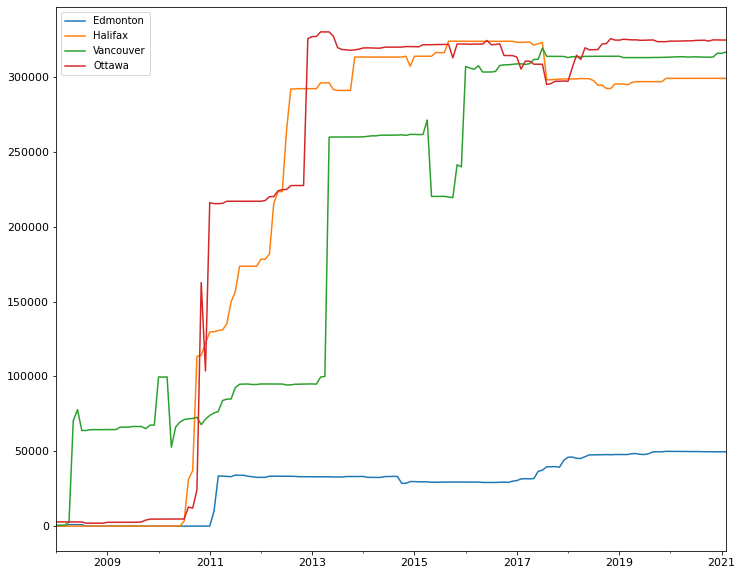

In [3]:
# defining and plotting request/path to natural_trees.txt?
def area():
    filter='(landuse=forest or natural=wood) and geometry:polygon'
    res = elements("/area/density/groupBy/boundary"
         ,filter=filter
         ,bpolys=regions
         ,time=t_mon)
    display(res.url)
    green = res.json()
    #display(body)
    df = pd.DataFrame()
    for groupBy in green['groupByResult']:
        series = pd.Series({row['timestamp']:row['value'] for row in groupBy['result']})
        df[groupBy['groupByObject']] = series
    df.set_index(pd.to_datetime(df.index),inplace=True)
    df.to_pickle("./df_density.pkl")
    df.plot(figsize=(12,10), fontsize=11)
area()

#### _In the graphic above you can see the development of the density of natural=wood/landuse=forest information_

When looking at the plot of the output dataset it is pretty safe to say that Edmonton has the lowest density of forest/wood information given when comparing it to the other regions. Although this might be part of low mapping activities too, it might as well be related to local oil and gas production areas or farmland which reduced the amount of forest. Another factor could be the general geographic connection to the Prairies Ecozone.

Furthermore it is worth mentioning that all cities, except Vancouver, only really added their forest information around 2010 and 2011 (Edmonton). 
Interestingly enough the density values for Vancouver, though starting to increase the earliest, remain quite low for the period between 2011-2013 and only cross parts with the Ottawa- and Halifax-values around 2017. Additionally there is a strong increase in density in the early 2013 months. _(potential reason?)_

Ottawa and Halifax both begin hold increasing information starting around the same period in 2010 and cross each other several times until Ottawa finally takes its place at the top in 2018. Density wise it (Ottawa) is the winner looking at the overall development of density throughout the years. However, it has a short … where it decreases in density between 2016 and 2017. _(potential reasons?)_

Canvec imports between 2010-2012 might be related to the strong increases during that time period as the natural tag (natural=wood) was part of the data given -> CanVec Vegetation (VE)

Another related (one-time) import might be one of Canadian Protected Areas which has been in progress since 2009 (from geogratis) but that is only an assumption

,region,mean,median,min,max
0,Vancouver,204006.882405,260064.895,614.07,319494.75
1,Halifax,223159.972215,296758.975,0.00,324080.16
2,Edmonton,28518.290506,32828.065,0.00,49962.98
3,Ottawa,234835.112468,316338.055,1942.07,330267.47


<AxesSubplot:ylabel='region'>

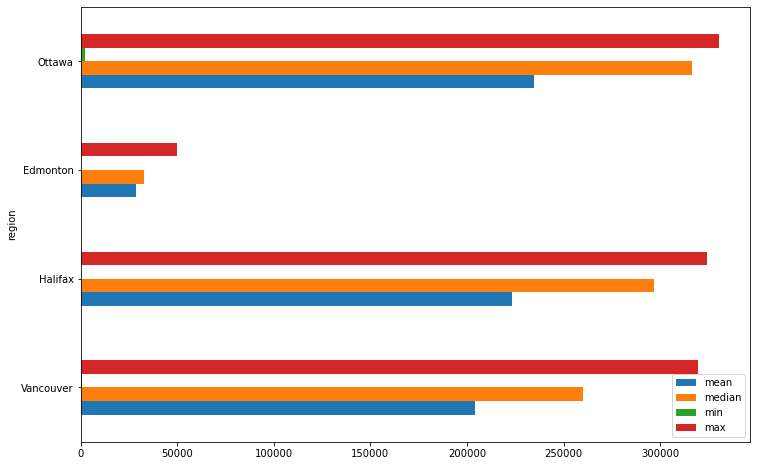

In [43]:
df_density = pd.read_pickle("./df_density.pkl")

val = {'region':['Vancouver', 'Halifax', 'Edmonton', 'Ottawa'], 
       'mean': [204006.8824050633, 223159.97221518986, 28518.290506329115, 234835.11246835446], 
       'median': [260064.895, 296758.975, 32828.065, 316338.055], 'min':[614.07, 0.0, 0.0, 1942.07], 
       'max':[319494.75, 324080.16, 49962.98, 330267.47]}
val_density = pd.DataFrame(val)

#df_density.plot(kind='box', figsize=(12,10), fontsize=9)
display (val_density)
val_density.plot.barh(0, figsize=(12,8))

#The table was created by searching for the mean, median, minimum and maximum values of each region.
#You can do it with numpy, like so:
#Ottawa, Ontario:
#Oarray = df_density['Ottawa']
#OttMean = np.mean(Oarray)
#OttMedian = np.median(Oarray)
#OttMin = np.min(Oarray)
#OttMax = np.max(Oarray)
#display("Ottawa")
#display(OttMean, OttMedian, OttMin, OttMax) #-> to look at the values

#### _Above you can see the output DataFrame 'val_density' with some statistics for the density dataset, below that it was visualized in a barchart_

Apart from Ottawa there is no display of a minimum value in the barchart above. That is due to the fact that Edmonton and Halifax both started at zero in the beginning of the examined timespan but also because the initial value of Metro Vancouver was much too small to be visibly display in the graphic.

When taking the chart into account one can once more see that Ottawa has the overall highest density values when taking e.g. the mean or maximum values into account, but even more so, it has the highest initial (minimum) values!
It is followed by Halifax, Vancouver and Edmonton comes last with the smallest overall values.

,region,Δ density,p [%]
0,Vancouver,316130.09,0.998061
1,Halifax,299203.41,1.000000
2,Edmonton,49647.97,1.000000
3,Ottawa,322071.36,0.991430


array([<AxesSubplot:title={'center':'Δ density'}, xlabel='region'>,
       <AxesSubplot:title={'center':'p [%]'}, xlabel='region'>],
      dtype=object)

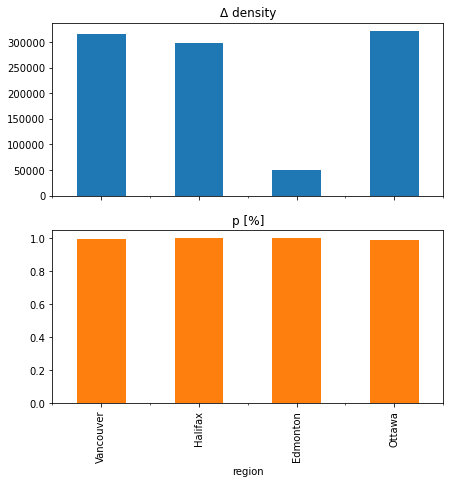

In [42]:
devdens = {'region':['Vancouver', 'Halifax', 'Edmonton', 'Ottawa'],
           'Δ density': [316130.09, 299203.41, 49647.97, 322071.36],
           'p [%]': [0.998060581278172, 1.0, 1.0, 0.9914301847182365]}
dev_density = pd.DataFrame(devdens)

display (dev_density)
dev_density.plot.bar(0, figsize=(7,7), legend=False, subplots=True)

#one way to calculate these values is:
#display(df_density)
#EdDiff = 49647.97 -  0.00
#EdPerc = EdDiff/49647.97
#display(EdDiff, EdPerc)

#### _Above you can see the Δ density and p%-values in numbers as well as figures. You can notice that the development for ALL regions was very good as the minimum percentuage of growth in density is in Ottawa with 99.143%_

A usual Edmonton shows the lowest Δ density values and Ottawa the highest. This is due to their overall development, yet it should be noted that the Δ density-values for Vancouver get really close to those of Ottawa and the starting values weren't much lower either which implies a very similar overall development overall the whole timespan. The values for Halifax are a little bit lower but still pretty close which leaves Edmonton with its unusually low values and could again be related to an overall low density in forests to be mapped in real life, especially considering the available CanVec data.

## **Analysis Part 2 - Users**

'https://api.ohsome.org/v1/users/count/groupBy/boundary'

""


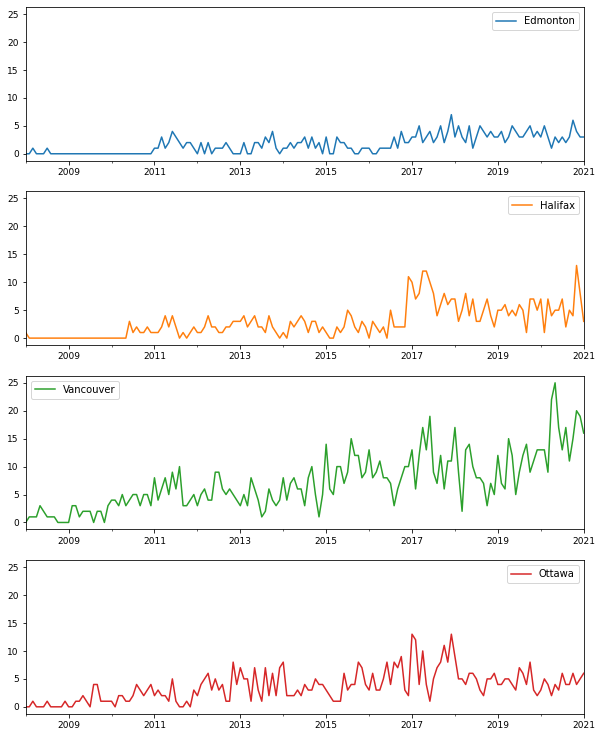

In [7]:
def groupBy():
    filter='landuse=forest or natural=wood'
    resU = users("/count/groupBy/boundary"
         ,filter=filter          
         ,bpolys=regions
         ,time=t_mon)
    display(resU.url)
    green_u = resU.json()
    #display(green_u)
    df = pd.DataFrame()
    display(df)
    for groupBy in green_u['groupByResult']:
        series = pd.Series({row['fromTimestamp']:row['value'] for row in groupBy['result']})
        df[groupBy['groupByObject']] = series
    df.set_index(pd.to_datetime(df.index),inplace=True)
    df.to_pickle("./df_users.pkl")
    df.plot(kind='line', subplots=True, sharex=False, sharey=True, figsize=(10,13), fontsize=9)
groupBy()

#### _In the graphic above you can see the user numbers of the natural=wood/landuse=forest tag over the years_

#### Edmonton:	  

Let's start from the top again.
There's almost no user activity from 2008 up until the end 2010 with merely two minor peaks in 2008. Notable user activity first starts around 2011 so at the same time as the main increase in density values. 
Remarkably so, one can observe that for certain time periods the user number keeps falling back to low or no user activity at all. After a phase of rather low values around the beginning of 2016 the peak is reached by the end of 2017 but even after there are still some quite high values. Furthermore, the peak also marks the time of the last notable increase in density information.


#### Halifax:	  

For the Halifax region there was nearly no user activity at all up until mid 2010 apart from a very short peak in the very beginning. The first peak in 2010 is in accord with the first strong density increase. However, after that the user numbers stay more or less on the same overall level until 2017 when they are peaking till mid 2017 which appears to be fitting the decreasing density values around this time period either. There's one last peak in 2020.


#### Vancouver: 

For the Metro Vancouver region there are only very short timespans of complete user inactivity and an overall increasing trend „observable“ although the plotted line is rather jagged-looking, meaning that there has been a quite strong variation in monthly user activity.
The maximum user count is reached around Mid 2020 whilst the first density peak is at the same time as the first peak in user activity 2008. The increasing trend in user counts begins at around 2010, yet shortly after there is a fast decrease in density probably due to wrong or double values that were corrected. This might be somewhat related to the CanVec imports as one of the most important data sources.

Additionally from 2010 on there were imports for Surrey BC which might be related as this city is part of the Metro Vancouver Region which was chosen as spatial boundary of this analysis according to local mapping community generally lots of data from aerial imagery data jump around the beginning of 2013 and relatively high though not unusual user activity.  

During that same year the Open Data Hackathon took place on Feb23rd as well as the Toronto hack weekend which might be related to the jump or maybe have motivated it (this is merely a presumtion). Furthermore, there is yet another pretty strong decrease in density-values in the beginning of 2015 which is during a phase of high user numbers followed by rather stable density values from ~2017 on with variable user activity as well as peak user activity in the beginning of 2020.

#### Ottawa:    

In Ottawa there are three times of minor user activity until 2009 and subsequently an increasing trend until 2018 with times of lower user activity between 2014 and Mid 2015. The local mapping community also states that most of the info is from canvac data.

,region,mean,median,min,max
0,Vancouver,7.191083,6.0,0.0,25.0
1,Halifax,2.878981,2.0,0.0,13.0
2,Edmonton,1.719745,1.0,0.0,7.0
3,Ottawa,3.681529,3.0,0.0,13.0


<AxesSubplot:>

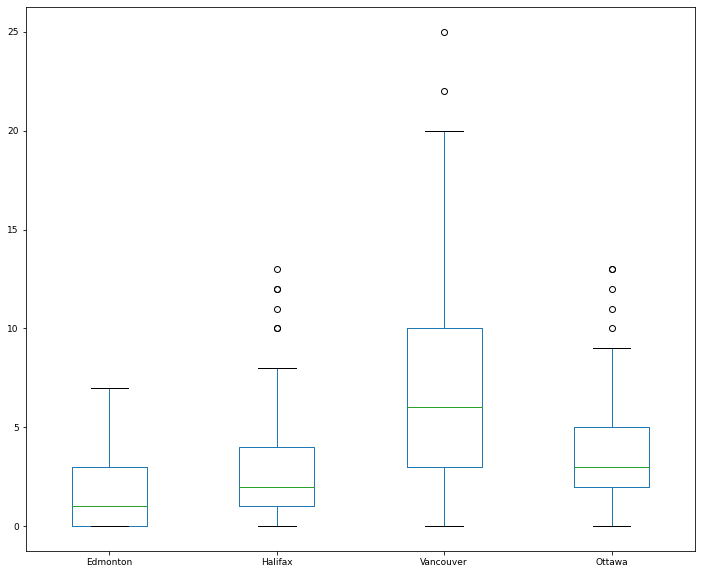

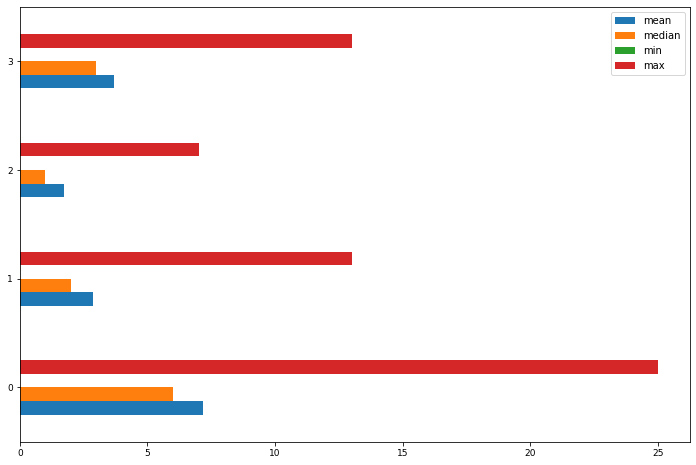

In [8]:
#read output dataset:
df_users = pd.read_pickle("./df_users.pkl")

val_u = {'region':['Vancouver', 'Halifax', 'Edmonton', 'Ottawa'], 
'mean': [7.191082802547771, 2.878980891719745, 1.7197452229299364, 3.6815286624203822], 
'median': [6.0, 2.0, 1.0, 3.0], 'min':[0.0, 0.0, 0.0, 0.0], 'max':[25.0, 13.0, 7.0, 13.0]}
val_users = pd.DataFrame(val_u)

df_users.plot(kind='box', figsize=(12,10), fontsize=9)
display (val_users)
val_users.plot.barh(fontsize=9, figsize=(12,8))


#The table was created by searching for the mean, median, minimum and maximum values of each region.
#You can do it with numpy, like so:
#Ottawa, Ontario:
#Oarray = df['Ottawa']
#OttMean = np.mean(Oarray)
#OttMedian = np.median(Oarray)
#OttMin = np.min(Oarray)
#OttMax = np.max(Oarray)
#display(OttMean, OttMedian, OttMin, OttMax) -> to look at the values

When looking at the minimum value of the user data output all the regions have the value 0, so during the time span looked at there were periods where there were no users of the request-tags at all.
Again, Edmonton hat the lowest values (mean, median & maximum) which might be yet another reason for the overall lower values in density of tree related polygon-tags.

Halifax and Ottawa both have the same maximum value yet Ottawa is higher in mean as well as median. And the highest overall user-values are to be found in Vancouver.

All regions but Edmonton have outliers which is in accord with the density values of Edmonton as there has been no visible mapping activity until 2011.